<a href="https://colab.research.google.com/github/1000century/Baekjoon/blob/main/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# 폰트 설정을 위한 코드
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv
!rm -rf ~/.cache/matplotlib/*

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=10)

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
fm._load_fontmanager(try_read_cache=False)
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 확인
print(mpl.rcParams['font.family'])
print(plt.rcParams['font.family'])

import seaborn as sns

# seaborn 스타일 설정
sns.set(font="NanumGothic", rc={"font.size":10, "axes.unicode_minus":False})

import unicodedata


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [39]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

from google.colab import drive
import zipfile

tensorflow version:  2.17.0
Using 0 GPUs


### 데이터

In [69]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Food Images/Kfood"

big_category = ['구이', '국', '기타', '김치', '나물', '면']
df_list = []

for category in big_category:
    extract_dir = os.path.join(base_path, category)

    csv_files = glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)

    for csv_file in csv_files:
        food = os.path.basename(os.path.dirname(csv_file))
        kf_df = pd.read_csv(csv_file, header=None, names=['filename', 'url', 'tmp'],encoding='utf-8-sig')
        kf_df['food_category'] = category
        kf_df['food_name'] = food
        kf_df['image_path'] = kf_df['filename'].apply(lambda x: os.path.join(os.path.dirname(csv_file), x))
        df_list.append(kf_df)

df = pd.concat(df_list, ignore_index=True)
df = df[df['image_path'].apply(os.path.exists)]

# 한글 자모음 분리되는 현상을 위한 코드 두 줄
df['food_name'] = df['food_name'].apply(lambda x: unicodedata.normalize('NFC', x))
df['food_category'] = df['food_category'].apply(lambda x: unicodedata.normalize('NFC', x))

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


filename                                                url  tmp  \
0  Img_012_0000.jpg  http://img.dongwonmall.com/dwmall/static_root/...  NaN   
1  Img_012_0002.JPG  http://postfiles3.naver.net/20140905_210/ridia...  NaN   
2  Img_012_0003.JPG  http://postfiles16.naver.net/20130208_287/smy2...  NaN   
3  Img_012_0004.jpg  http://cfile205.uf.daum.net/image/114587404D2F...  NaN   
4  Img_012_0005.jpg  http://cfile235.uf.daum.net/image/115FCF344F65...  NaN   

  food_category food_name                                         image_path  
0            구이      황태구이  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
1            구이      황태구이  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
2            구이      황태구이  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
3            구이      황태구이  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
4            구이      황태구이  /content/drive/MyDrive/Food Images/Kfood/구이/구...

In [70]:
print("DataFrame 샘플:")
print(f"총 이미지 수: {len(df)}")
print(f"음식 카테고리 수: {df['food_category'].nunique()}")
print(f"음식 종류 수: {df['food_name'].nunique()}")

print("\n음식별 이미지 수:")
print(df['food_name'].value_counts())

DataFrame 샘플:
총 이미지 수: 13753
음식 카테고리 수: 4
음식 종류 수: 37

음식별 이미지 수:
food_name
수제비       704
불고기       648
칼국수       549
잔치국수      503
삼겹살       495
닭갈비       480
떡국_만두국    480
비빔냉면      475
물냉면       447
떡갈비       441
미역국       384
콩나물국      384
콩국수       384
오이소박이     371
고등어구이     370
열무국수      368
장어구이      368
열무김치      366
북엇국       361
배추김치      341
막국수       336
무국        334
갈치구이      314
총각김치      314
부추김치      297
파김치       294
시래기국      293
황태구이      291
계란국       290
깍두기       288
나박김치      273
더덕구이      270
육개장       267
무생채       261
갈비구이      241
갓김치       236
훈제오리      235
Name: count, dtype: int64


In [81]:
df = df.drop(['url','tmp'],axis=1)
df.head()

filename food_category food_name  \
0  Img_012_0000.jpg            구이      황태구이   
1  Img_012_0002.JPG            구이      황태구이   
2  Img_012_0003.JPG            구이      황태구이   
3  Img_012_0004.jpg            구이      황태구이   
4  Img_012_0005.jpg            구이      황태구이   

                                          image_path  
0  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
1  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
2  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
3  /content/drive/MyDrive/Food Images/Kfood/구이/구...  
4  /content/drive/MyDrive/Food Images/Kfood/구이/구...

In [80]:
TARGET = list(df['food_name'].unique())
TARGET = [unicodedata.normalize('NFC', item) for item in TARGET]
print(*[TARGET[i:i+10] for i in range(0, len(TARGET), 10)], sep='\n')
print(len(TARGET))

['황태구이', '불고기', '장어구이', '떡갈비', '더덕구이', '갈치구이', '삼겹살', '고등어구이', '갈비구이', '훈제오리']
['닭갈비', '무국', '미역국', '계란국', '떡국_만두국', '북엇국', '육개장', '콩나물국', '시래기국', '총각김치']
['오이소박이', '배추김치', '나박김치', '부추김치', '갓김치', '깍두기', '열무김치', '파김치', '무생채', '물냉면']
['열무국수', '막국수', '칼국수', '잔치국수', '수제비', '비빔냉면', '콩국수']
37


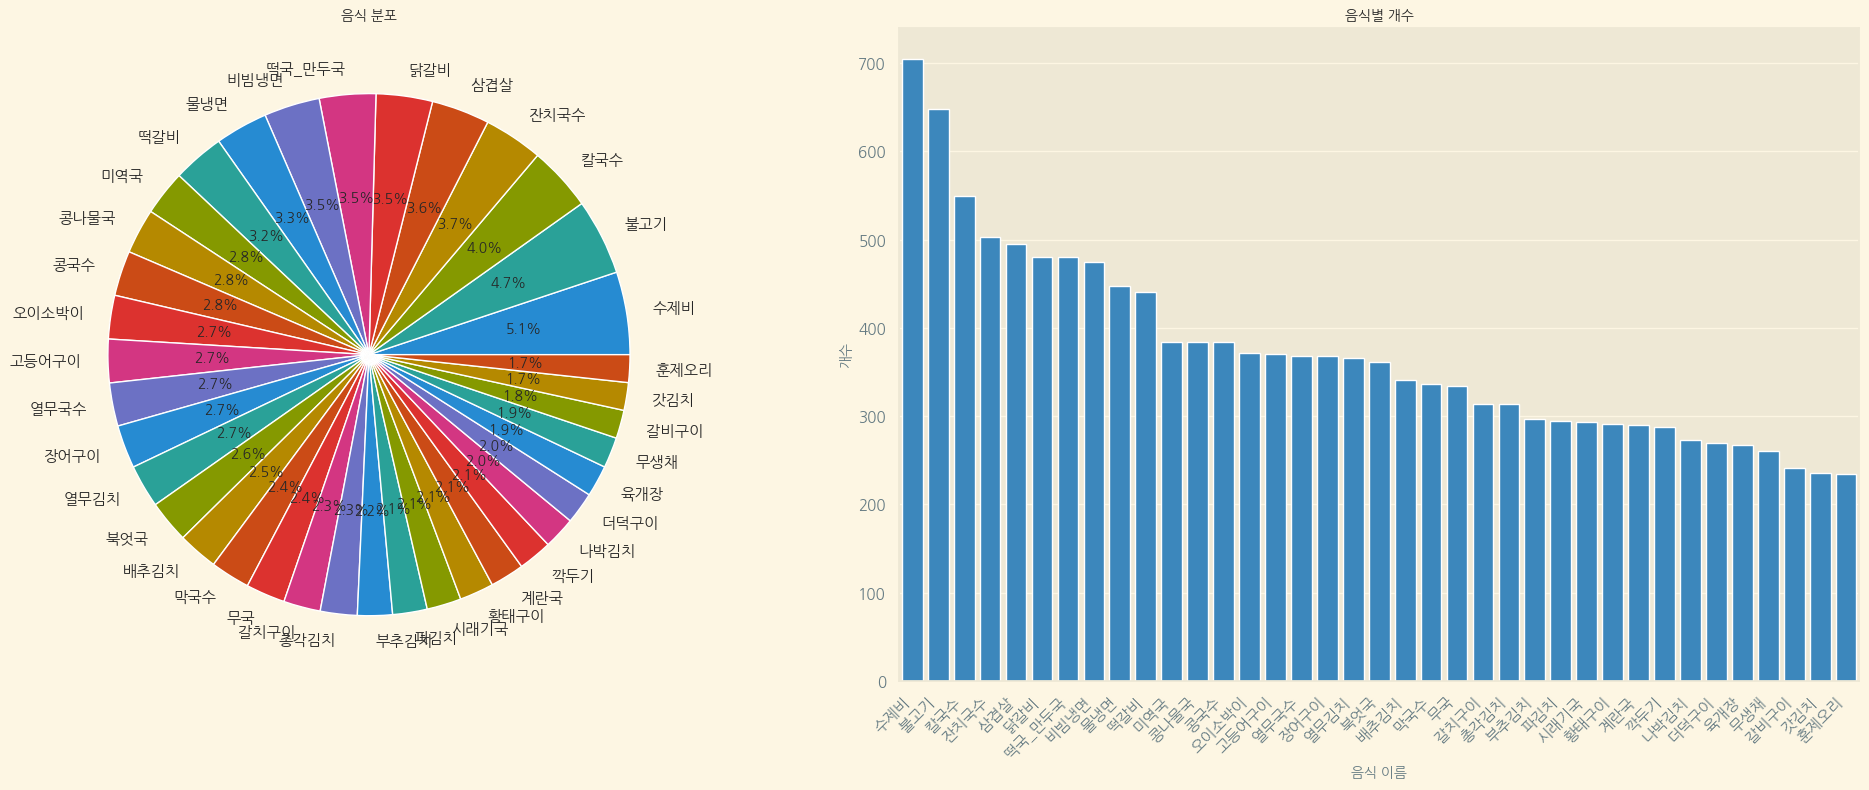

In [75]:
label_counts = df['food_name'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%.1f%%')
plt.title('음식 분포', fontproperties=font_prop)

plt.subplot(1,2,2)
sns.countplot(x=df['food_name'], order=label_counts.index)
plt.xticks(rotation=45, ha='right')
plt.title('음식별 개수', fontproperties=font_prop)
plt.xlabel('음식 이름', fontproperties=font_prop)
plt.ylabel('개수', fontproperties=font_prop)

plt.tight_layout()
plt.show()

### 훈련 데이터, 테스트 데이터 분리

In [58]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [84]:
for col in df['food_name'].unique():
    df_test[col] = np.where(df_test['food_name'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['food_name'].str.contains(col), 1.0, 0.0).astype('float32')

### DataGenerator

In [86]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None, target_col='food_name', **kwargs):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.target_col = target_col
        self.augmentation_settings = kwargs
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        X = self.__apply_augmentations(X)

        # preprocess가 설정된 경우만 적용
        if self.preprocess is not None:
            X = self.preprocess(X)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 256, 256, 3), dtype='float32')
        y = np.zeros((len(indexes),), dtype='object')  # 타겟을 문자열로 저장

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['image_path']
            img = Image.open(path).convert('RGB')
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j, :, :] = img
            y[j] = row[self.target_col]

        return X, y

    def __apply_augmentations(self, img_batch):
        if self.augmentation_settings.get('resize', False):
            img_batch = self.__resize(img_batch)
        if self.augmentation_settings.get('rotate', False):
            img_batch = self.__rotate(img_batch)
        if self.augmentation_settings.get('zoom', False):
            img_batch = self.__zoom(img_batch)
        if self.augmentation_settings.get('warp', False):
            img_batch = self.__warp(img_batch)
        if self.augmentation_settings.get('lighting', False):
            img_batch = self.__lighting(img_batch)
        if self.augmentation_settings.get('flip', False):
            img_batch = self.__flip(img_batch)
        if self.augmentation_settings.get('erasing', False):
            img_batch = self.__erasing(img_batch)
        if self.augmentation_settings.get('normalize', False) and self.preprocess is None:
            img_batch = self.__normalize(img_batch)
        if self.augmentation_settings.get('mixup', False):
            img_batch = self.__mixup(img_batch)
        return img_batch

    def __resize(self, img_batch):
        target_size = self.augmentation_settings.get('resize_target', (320, 320))
        composition = albu.Compose([
            albu.Resize(height=target_size[0], width=target_size[1], always_apply=True),
            albu.Resize(height=256, width=256, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __rotate(self, img_batch):
        limit = self.augmentation_settings.get('rotate_limit', 20)
        prob = self.augmentation_settings.get('rotate_prob', 0.75)
        composition = albu.Compose([
            albu.Rotate(limit=limit, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __zoom(self, img_batch):
        scale = self.augmentation_settings.get('zoom_scale', (0.8, 1.2))
        prob = self.augmentation_settings.get('zoom_prob', 0.75)
        composition = albu.Compose([
            albu.RandomScale(scale_limit=(scale[0]-1, scale[1]-1), p=prob),
            albu.Resize(height=256, width=256, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __warp(self, img_batch):
        alpha = self.augmentation_settings.get('warp_alpha', 100)
        sigma = self.augmentation_settings.get('warp_sigma', 10)
        prob = self.augmentation_settings.get('warp_prob', 0.75)
        composition = albu.Compose([
            albu.ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=None, p=prob),  # Set alpha_affine to None
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __lighting(self, img_batch):
        brightness = self.augmentation_settings.get('brightness_limit', 0.2)
        contrast = self.augmentation_settings.get('contrast_limit', 0.2)
        prob = self.augmentation_settings.get('lighting_prob', 0.75)
        composition = albu.Compose([
            albu.RandomBrightnessContrast(brightness_limit=brightness, contrast_limit=contrast, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __flip(self, img_batch):
        prob = self.augmentation_settings.get('flip_prob', 0.5)
        composition = albu.Compose([
            albu.HorizontalFlip(p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __erasing(self, img_batch):
        max_holes = self.augmentation_settings.get('erasing_max_holes', 8)
        max_height = self.augmentation_settings.get('erasing_max_height', 8)
        max_width = self.augmentation_settings.get('erasing_max_width', 8)
        prob = self.augmentation_settings.get('erasing_prob', 0.5)
        composition = albu.Compose([
            albu.CoarseDropout(max_holes=max_holes, max_height=max_height, max_width=max_width, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __normalize(self, img_batch):
        mean = self.augmentation_settings.get('normalize_mean', (0.485, 0.456, 0.406))
        std = self.augmentation_settings.get('normalize_std', (0.229, 0.224, 0.225))
        composition = albu.Compose([
            albu.Normalize(mean=mean, std=std, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __mixup(self, img_batch):
        alpha = self.augmentation_settings.get('mixup_alpha', 0.2)
        prob = self.augmentation_settings.get('mixup_prob', 0.1)
        if np.random.rand() > prob:
            return img_batch

        batch_size = img_batch.shape[0]
        lam = np.random.beta(alpha, alpha, batch_size)
        lam = np.max([lam, 1-lam], axis=0)
        index = np.random.permutation(batch_size)

        lam = lam.reshape(batch_size, 1, 1, 1)
        mixed_img_batch = lam * img_batch + (1 - lam) * img_batch[index]
        return mixed_img_batch

    def __apply_augmentation(self, img_batch, composition):
        for i in range(img_batch.shape[0]):
            img_batch[i] = composition(image=img_batch[i])['image']
        return img_batch


In [87]:
!pip install -q git+https://github.com/qubvel/classification_models.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


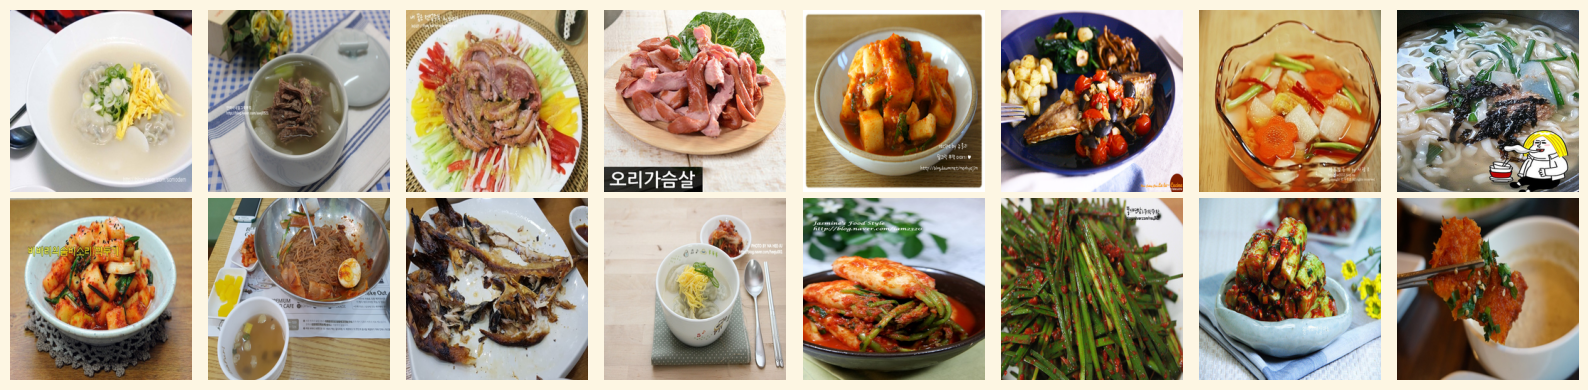

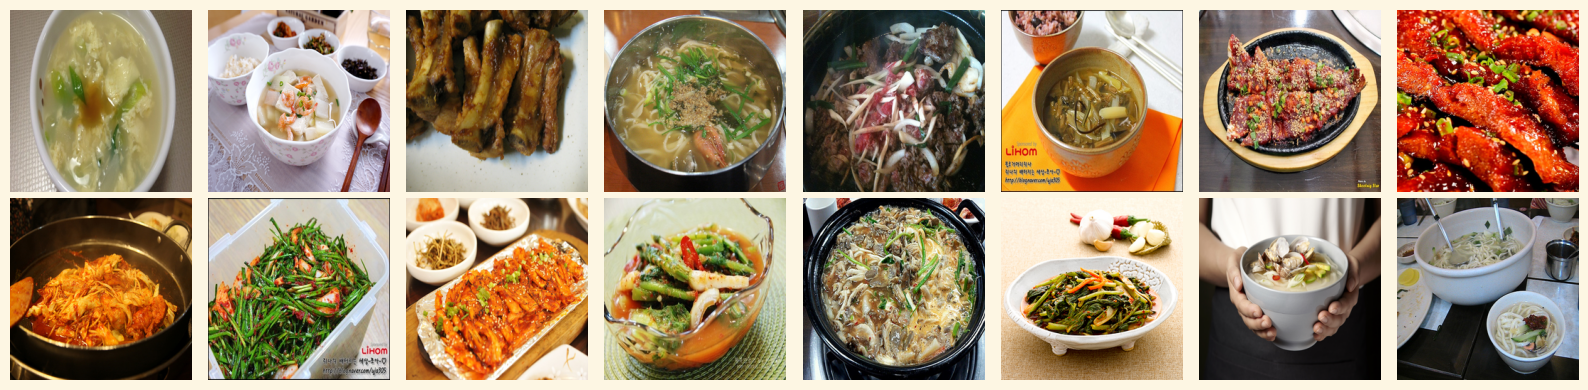

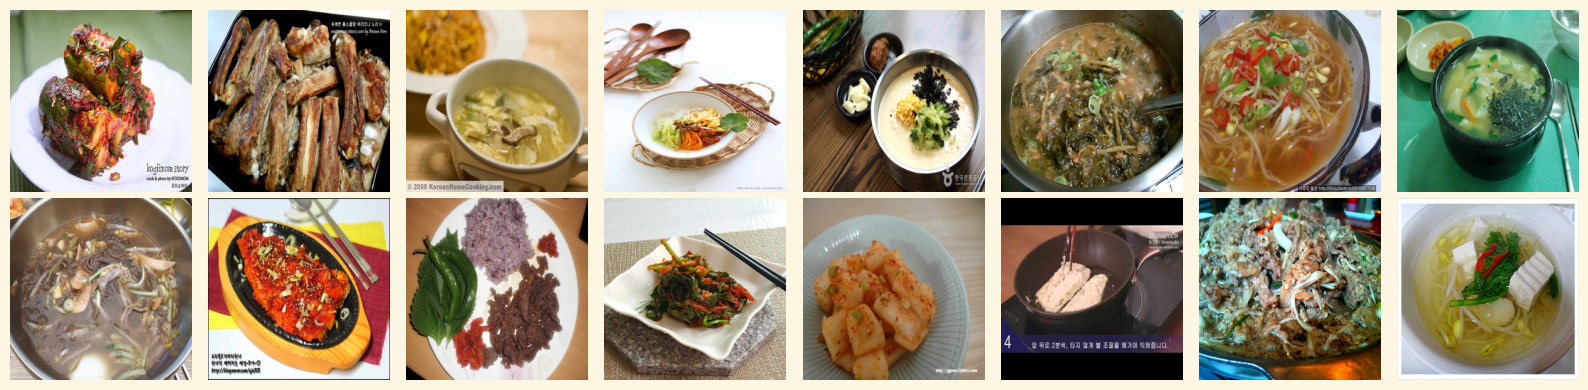

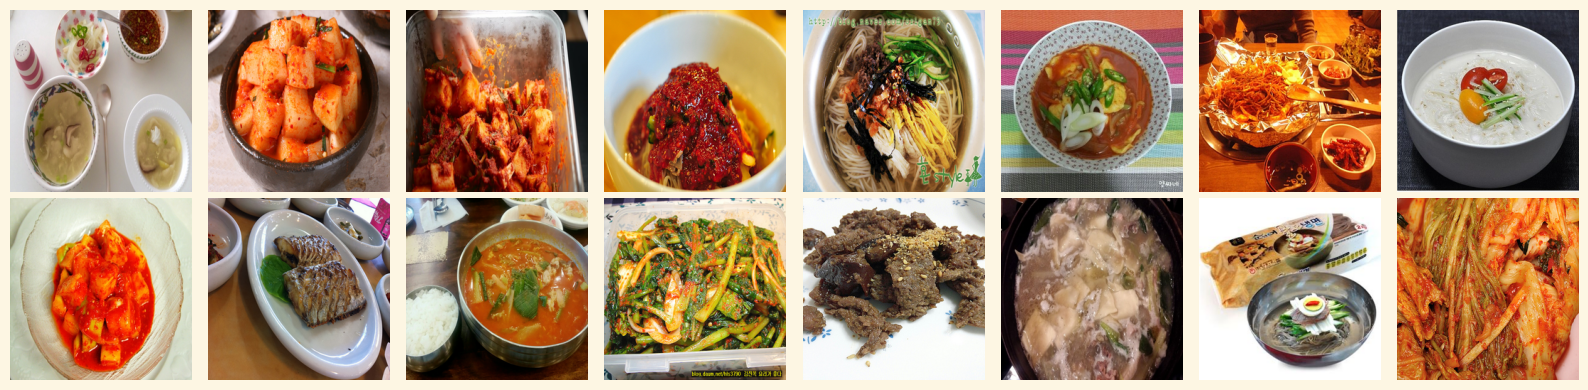

In [89]:
from classification_models.tfkeras import Classifiers

# ResNet18 모델과 전처리 함수 가져오기
resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS,COLS = 2,8

gen = DataGenerator(df_train, batch_size=ROWS * COLS, shuffle=False, preprocess=None)

for i, (x, y) in enumerate(gen):
    plt.figure(figsize=(COLS * 2, ROWS * 2))

    for j in range(x.shape[0]):
        plt.subplot(ROWS, COLS, j + 1)

        img = x[j, :, :, :3]
        plt.imshow(img.astype('uint8'))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if i == 3: break